In [15]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import math

np.random.seed(1337)

_e = 2.7182818284

def z_score(t, mu, sd):
    return abs((t - mu) / sd)

def Polya_tail(z):
    y = 1 - _e ** (-0.63661977236 * z ** 2)
    return (1 + np.sqrt(y)) / 2

def Winitzki_tail(z):
    a = -z ** 2 / 2
    b = 0.147 * a
    c = 1 - _e ** (a * (1.27323954474 + b) / (1 + b))
    return 0.5 * (1 + c ** 0.5)

def Lin_tail(z):
    y = 13.1946891451 * z / (9 - z)
    return 1 - 1 / (1 + _e ** y)

def calculate_w(t, zp):
    zn = z_score(t)
    w = zp - zn
    return w

Here we test our approximation functions adapted from the text, using constants of 10 decimal places.  The EVM can only support floating point math to this level of depth.

Testing the approximations of right tails of the normal distribution at a specific point:  At 2 standard deviations, exactly 98% of the area should fall under the curve, to the left of the point.  These algorithms don't support negative Z scores, as you can always subtract them from 1 if you are on the left.

In [16]:
print(z_score(4, 6, 1)) # 2 -- 98%
Lin_tail(2), Polya_tail(2), Winitzki_tail(2) 

2.0


(0.9774654043004543, 0.9800111797869381, 0.9841464769442516)

At this point, we should determine what most closely approximates the real distribution, or figure out which ones are the best in certain regions.  Then, probably using a combination in a piecewise function, we can establish a method that is useful to determine payouts of the cryptobond and allows us to reach time of maturity without going bankrupt.

In [17]:
table = pd.DataFrame(columns=['t', 'z', 'cdf', 'lin', 'polya', 'winitzki'])

# Integer time, Z score, and true cumulative distribution function
table['t'] = range(0, 10000)
table['z'] = z_score(table['t'], 5000, 2000)
table['cdf'] = norm.cdf(table['z'])

# 3 numerical methods for approximation of the CDF
table['lin'] = Lin_tail(table['z'])
table['polya'] = Polya_tail(table['z'])
table['winitzki'] = Winitzki_tail(table['z'])

table.iloc[:5000, 2:] = 1 - table.iloc[0:5000, 2:]
table.head()

,t,z,cdf,lin,polya,winitzki
0,0,2.5000,0.006210,0.006213,0.004699,0.002269
1,1,2.4995,0.006218,0.006222,0.004706,0.002274
2,2,2.4990,0.006227,0.006230,0.004714,0.002280
3,3,2.4985,0.006236,0.006239,0.004721,0.002285
4,4,2.4980,0.006245,0.006248,0.004729,0.002291


For our purposes, a single simple short function which errs always on one side or the other of the real curve is ideal.  If there is more than one that false completely inside or outside of the curve, we find out which runs faster.  If they run at the same speed, we take the one with the smallest memory footprint.

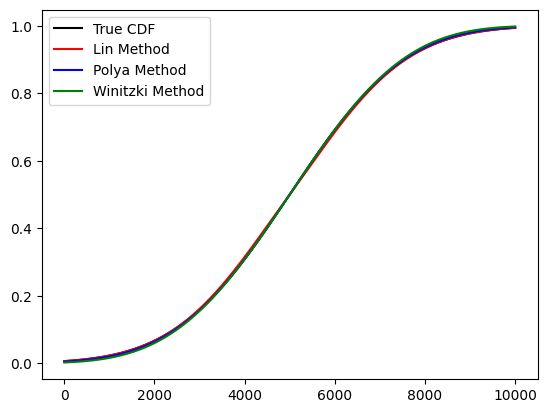

In [18]:
plt.plot(table['t'], table['cdf'], color='black', label = 'True CDF')
plt.plot(table['t'], table['lin'], color='red', label = 'Lin Method')
plt.plot(table['t'], table['polya'], color='blue', label = 'Polya Method')
plt.plot(table['t'], table['winitzki'], color='green', label = 'Winitzki Method')
plt.legend()

At the mean, all of these approximators are basically accurate.  This stands to reason.  At the extreme left-hand and right-hand side of the CDF, they also converge.  It appears that the greatest deviations from the true values occur when the Z score false in the intervals (1,2) and (-1,-2).

These differences matter because the area under the curve in the true CDF is equal to exactly 1.  These other approximations may be a little less or a little more than 1 in total.  Finding out exactly where divergences occur will give us a useful piecewise function or let us know that we can just use the simplest approximation.  It will also be important to see how much time each calculation takes.

First, we take random samples from the time frame to create slices of the curve and add them together to see how close they are to 1.  If the sum of the slices does not exceed 1 (in every single experiment), this is an indication that the approximation can be used as is.

In [19]:
# Create n random time intervals with Z score
def make_slices(n=20, T=10000, mu=5000, sd=2000):
    
    # Start on the left side of the curve
    t = [0]
    z = [-2.50]

    # Pick random times for trades within the timeframe T
    for i in range(n):
        t.append(np.random.randint(t[-1]+1, T))
        if t[-1] >= T-1:
            break
        elif t[-1] < mu:
            z.append(0 - z_score(t[-1], mu, sd))
        else:
            z.append(z_score(t[-1], mu, sd))
    return t,z

def make_test(n=100):
    t,z = make_slices(n)
    trades = []
    for i in range(len(z) - 1):
        left = Lin_tail(z[i])
        right = Lin_tail(z[i+1])
        trades.append(abs(left - right))
    return trades
    
sum(make_test())

0.9400322219456965

After implementing this "solution", I find that Vyper is unable to perform expnentiation on decimal numbers!  What a terrible discovery!  Raising Euler's number to a power computed at runtime is crucial to the smart contract as imagined.

The only solution I can imagine is to scale the number by a multiple of 10 and perform the exponential on that.... then to scale it back to its original magnitude.  This is going to hurt.....

Fortunately, we can represent numbers as binary, and we can precompute as magic numbers certain relevant constants.  Then we can use bitwise operators, moving the relevant 1s and 0s left or right, and finally return the numbers to our original base and magnitude.

a hint from https://stackoverflow.com/questions/69954589/is-there-a-way-in-vyper-to-calculate-ex-with-x-being-a-signed-decimal

import math

SCALE = 10

EXP = 3

eScaled = math.e * (10 ** SCALE)

eScaleDiv = (10 ** SCALE) ** EXP

ePowExpScaled = eScaled ** EXP

print(ePowExpScaled / eScaleDiv)

print(math.e ** EXP)

In [20]:
def Lin_scaled(z):
    scale = 10 ** 10
    y = 13.1946891451 * z / (9 - z)
    exp = int(_e * scale)
    
    y_scaled = scale ** y
    exp_scaled = exp ** y
    return 1 - 1 / (1 + exp_scaled / y_scaled)

print(Lin_tail(1.2))
print(Lin_scaled(1.2))

0.8839061705238646
0.8839061705238646


In [57]:
def erf(x):
    """
    List whole, tenth, and hundredth powers of e.
    Compute the non-integer power of e by the product rule of exponents.
    """
    ones = [1.0, 2.7182818285, 7.3890560989, 20.0855369232, 54.5981500331,
        148.4131591026, 403.4287934927, 1096.6331584285, 2980.9579870417,
        8103.0839275754]
    tenths = [1.0, 1.11, 1.23, 1.35, 1.5, 1.65, 1.83, 2.02, 2.23, 2.46]
    hundredths = [1.0, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1]

    r = int(x)
    f10 = int(x * 10 - r * 10)
    f100 = int(x * 100 - r * 100 - f10 * 10)

    print(r, f10, f100)
    ans = hundredths[int(f100)] * tenths[int(f10)] * ones[r]
    return ans

In [63]:
4.2 * math.pi

13.194689145077131

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 8
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 7
0 5 9
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 6 8
0 6 9
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 7 8
0 7 9
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 8 8
0 8 9
0 9 0
0 9 1
0 9 2
0 9 3
0 9 4
0 9 5
0 9 6
0 9 7
0 9 8
0 9 9
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 0 5
1 0 6
1 0 7
1 0 8
1 0 9
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 1 5
1 1 7
1 1 8
1 1 9
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 2 8
1 2 9
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 3 5
1 3 6
1 3 7
1 3 8
1 3 9
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
1 4 5
1 4 6
1 4 7
1 4 8
1 4 9
1 5 0
1 5 1
1 5 2
1 5 3
1 5 4
1 5 5
1 5 6
1 5 7
1 5 8
1 5 9
1 6 0
1 6 1
1 6 2
1 6 3
1 6 4
1 6 5
1 6 

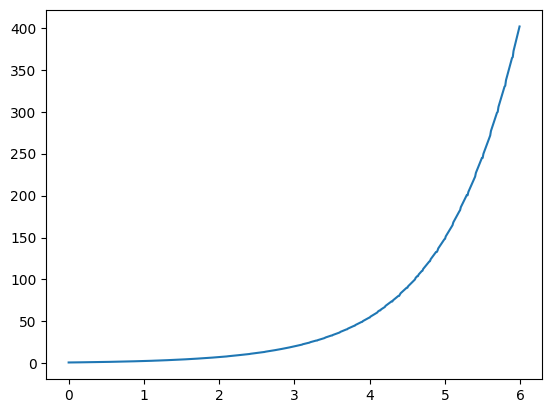

In [62]:
zrange = np.arange(0, 6, 0.01)
plt.plot(zrange, [erf(z) for z in zrange])

In [61]:
# thousandths powers of e
[round(math.exp(0.1*i), ndigits=3) for i in range(10)]

[1.0, 1.105, 1.221, 1.35, 1.492, 1.649, 1.822, 2.014, 2.226, 2.46]